In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']

import numpy as np
import math, sys, os, glob
import scipy.linalg as sl
import scipy.special as ss
import scipy.constants as sc
import scipy.misc as scmisc
import scipy.integrate as si
from scipy.interpolate import interp1d

import george
import george.kernels as kernels
import emcee
import corner

import cPickle as pickle

try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

Msol = 1.98855*10.0**30.0
yr = 365.25 * 86400.0

In [3]:
def figsize(scale):
    fig_width_pt = 469.755                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
                                'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        'figure.figsize': (3.39,2.1)}
plt.rcParams.update(params)

## Let's read in the population synthesis spectra. These spectra cover a range of stellar density values and initial binary eccentricities.

In [15]:
filnames = glob.glob('./data/*.gz')

In [16]:
aa = []
bb = []
for ii in range(len(filnames)):
    aa.append(filnames[ii].split('_')[-3].split('Rho')[1])
    bb.append(filnames[ii].split('_')[-2].split('Ecc')[1])

In [17]:
aa = np.unique(np.array(aa))
bb = np.unique(np.array(bb))

aa = aa[np.argsort(aa.astype(float))]

In [18]:
data = []
ct = 0
for stars in aa:
    for ecc in bb:
        data.append(np.loadtxt('./data/Spectra_Rho{0}_Ecc{1}_HundredYears.gz'.format(str(stars),str(ecc))))
        print ct, stars, ecc
        ct += 1

0 100 00
1 100 075
2 100 150
3 100 225
4 100 300
5 100 375
6 100 450
7 100 525
8 100 600
9 100 675
10 100 750
11 100 825
12 100 900
13 100 950
14 125 00
15 125 075
16 125 150
17 125 225
18 125 300
19 125 375
20 125 450
21 125 525
22 125 600
23 125 675
24 125 750
25 125 825
26 125 900
27 125 950
28 150 00
29 150 075
30 150 150
31 150 225
32 150 300
33 150 375
34 150 450
35 150 525
36 150 600
37 150 675
38 150 750
39 150 825
40 150 900
41 150 950
42 175 00
43 175 075
44 175 150
45 175 225
46 175 300
47 175 375
48 175 450
49 175 525
50 175 600
51 175 675
52 175 750
53 175 825
54 175 900
55 175 950
56 200 00
57 200 075
58 200 150
59 200 225
60 200 300
61 200 375
62 200 450
63 200 525
64 200 600
65 200 675
66 200 750
67 200 825
68 200 900
69 200 950
70 225 00
71 225 075
72 225 150
73 225 225
74 225 300
75 225 375
76 225 450
77 225 525
78 225 600
79 225 675
80 225 750
81 225 825
82 225 900
83 225 950
84 250 00
85 250 075
86 250 150
87 250 225
88 250 300
89 250 375
90 250 450
91 250 525
92 25

In [19]:
data = np.array(data)

aa = aa.astype(float) / 100.0 # log10 of stellar density
bb = bb.astype(float) / 1000.0 # eccentricity

## We have the characteristic strain spectra starting at 1/(100-yrs). Let's re-bin the spectra for a 30-yr baseline instead of 100-yrs. 

## Also, let's just look at the characteristic strain at one frequency, f_gw = 1/(30-yrs)

In [20]:
freq_ind = 0

newfreqs = np.arange(1.0,100.0) / (30.0*365.25*86400.0)
newwidth = newfreqs[1]-newfreqs[0]
newstrain = np.zeros((data.shape[0],data.shape[1]-1))

finefreqs = data[0,0,:] # same for all parameter inputs
finestrain = data[:,1:,:]
finewidth = finefreqs[1] - finefreqs[0]

for ii in range(data.shape[0]):
    for jj in range(data.shape[1]-1):
        
        mask = np.logical_and(finefreqs >= (newfreqs[freq_ind] - newwidth/2.), 
                              finefreqs <= (newfreqs[freq_ind] + newwidth/2.))
        
        newstrain[ii,jj] = np.sum(finestrain[ii,jj,mask]) * finewidth / newwidth 

## Compute mean strain spectrum and std (from Poissonian realization variance) from new binning. This becomes our data.

In [21]:
newmean = np.mean(np.log10(np.sqrt(newstrain)/1e-15),axis=1)
newerr = np.std(np.log10(np.sqrt(newstrain)/1e-15),axis=1)

In [22]:
# Sort data in 2-d space of density and eccentricity into one long vector

xobs = np.zeros((len(aa)*len(bb),2))
    
A, B = np.meshgrid(aa,bb)

xobs[:,0] = A.flatten(order='F') # iterates over all eccentricities then all stellar densities
xobs[:,1] = B.flatten(order='F')

yobs = newmean
yerr = newerr

## Now we have the data. So let's set up the Gaussian Process (GP), using the George GP regression library.

In [23]:
# We use a Squared-Exponential kernel

k = 1.0 * kernels.ExpSquaredKernel([0.5,0.5],ndim=2)

In [24]:
# Instantiate the GP

gp = george.GP(k)

In [25]:
# Pre-compute the factorization of the matrix.

gp.compute(xobs, yerr)

In [26]:
# Compute the log likelihood of the data, given the GP model.

print(gp.lnlikelihood(yobs))

112.83612519


## OK. Let's try predicting new values for the strain spectrum between the training points, i.e. at new values of stellar-density and eccentricity.

In [27]:
# Define prediction points

t = np.zeros((10000,2))
    
xx = np.linspace(1.0,4.0,100) # log10(\rho / Msol.pc^{-3}) in U[1.0,4.0] 
yy = np.linspace(0.0,0.95,100) # e_0 in U[1.0,4.0] 

X, Y = np.meshgrid(xx,yy)

t[:,0] = X.flatten(order='F')
t[:,1] = Y.flatten(order='F')

## Predict the characteristic strain across astrophysical parameter space, and give a prediction uncertainity.

In [28]:
mu, cov = gp.predict(yobs, t)
std = np.sqrt(np.diag(cov))

## The above is fine, but really we should train our GP kernel parameters on the simulation data. So, let's optimize the kernel parameters.

In [29]:
# Define a GP class containing the kernel parameter priors and a log-likelihood

class gaussproc(object):
    
    def __init__(self, x, y, yerr=None):
        
        self.x = x
        self.y = y
        self.yerr = yerr
        
        self.pmax = np.array([20.0, 20.0, 20.0])
        self.pmin = np.array([-20.0, -20.0, -20.0])
        self.emcee_flatchain = None
        self.emcee_flatlnprob = None
        self.emcee_kernel_map = None
    
    def lnprior(self, p):
    
        logp = 0.
    
        if np.all(p <= self.pmax) and np.all(p >= self.pmin):
            logp = np.sum(np.log(1/(self.pmax-self.pmin)))
        else:
            logp = -np.inf

        return logp

    def lnlike(self, p):

        # Update the kernel and compute the lnlikelihood.
        a, tau = np.exp(p[0]), np.exp(p[1:3])
        
        lnlike = 0.0
        try:
            gp = george.GP(a * kernels.ExpSquaredKernel(tau,ndim=2))
            #gp = george.GP(a * kernels.Matern32Kernel(tau))
            gp.compute(self.x , self.yerr)
            
            lnlike = gp.lnlikelihood(self.y, quiet=True)
        except np.linalg.LinAlgError:
            lnlike = -np.inf
        
        return lnlike
    
    def lnprob(self, p):
        
        return self.lnprior(p) + self.lnlike(p)

In [31]:
# Instanciate a GP again 

gp_george = gaussproc(xobs,yobs,yerr)
    
k = 1.0 * kernels.ExpSquaredKernel([2.0,2.0],ndim=2)
num_kpars = len(k) 

In [32]:
# Use emcee (http://dan.iel.fm/emcee/current/) to sample the 
# posterior distribution of the kernel parameters to find MAP value

nwalkers, ndim = 36, num_kpars
sampler = emcee.EnsembleSampler(nwalkers, ndim, gp_george.lnprob)

# Initialize the walkers.
p0 = [np.log([1.,1.,1.]) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

print "Running burn-in"
p0, lnp, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print "Running second burn-in"
p = p0[np.argmax(lnp)]
p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print "Running production"
p0, _, _ = sampler.run_mcmc(p0, 1000)

Running burn-in
Running second burn-in
Running production


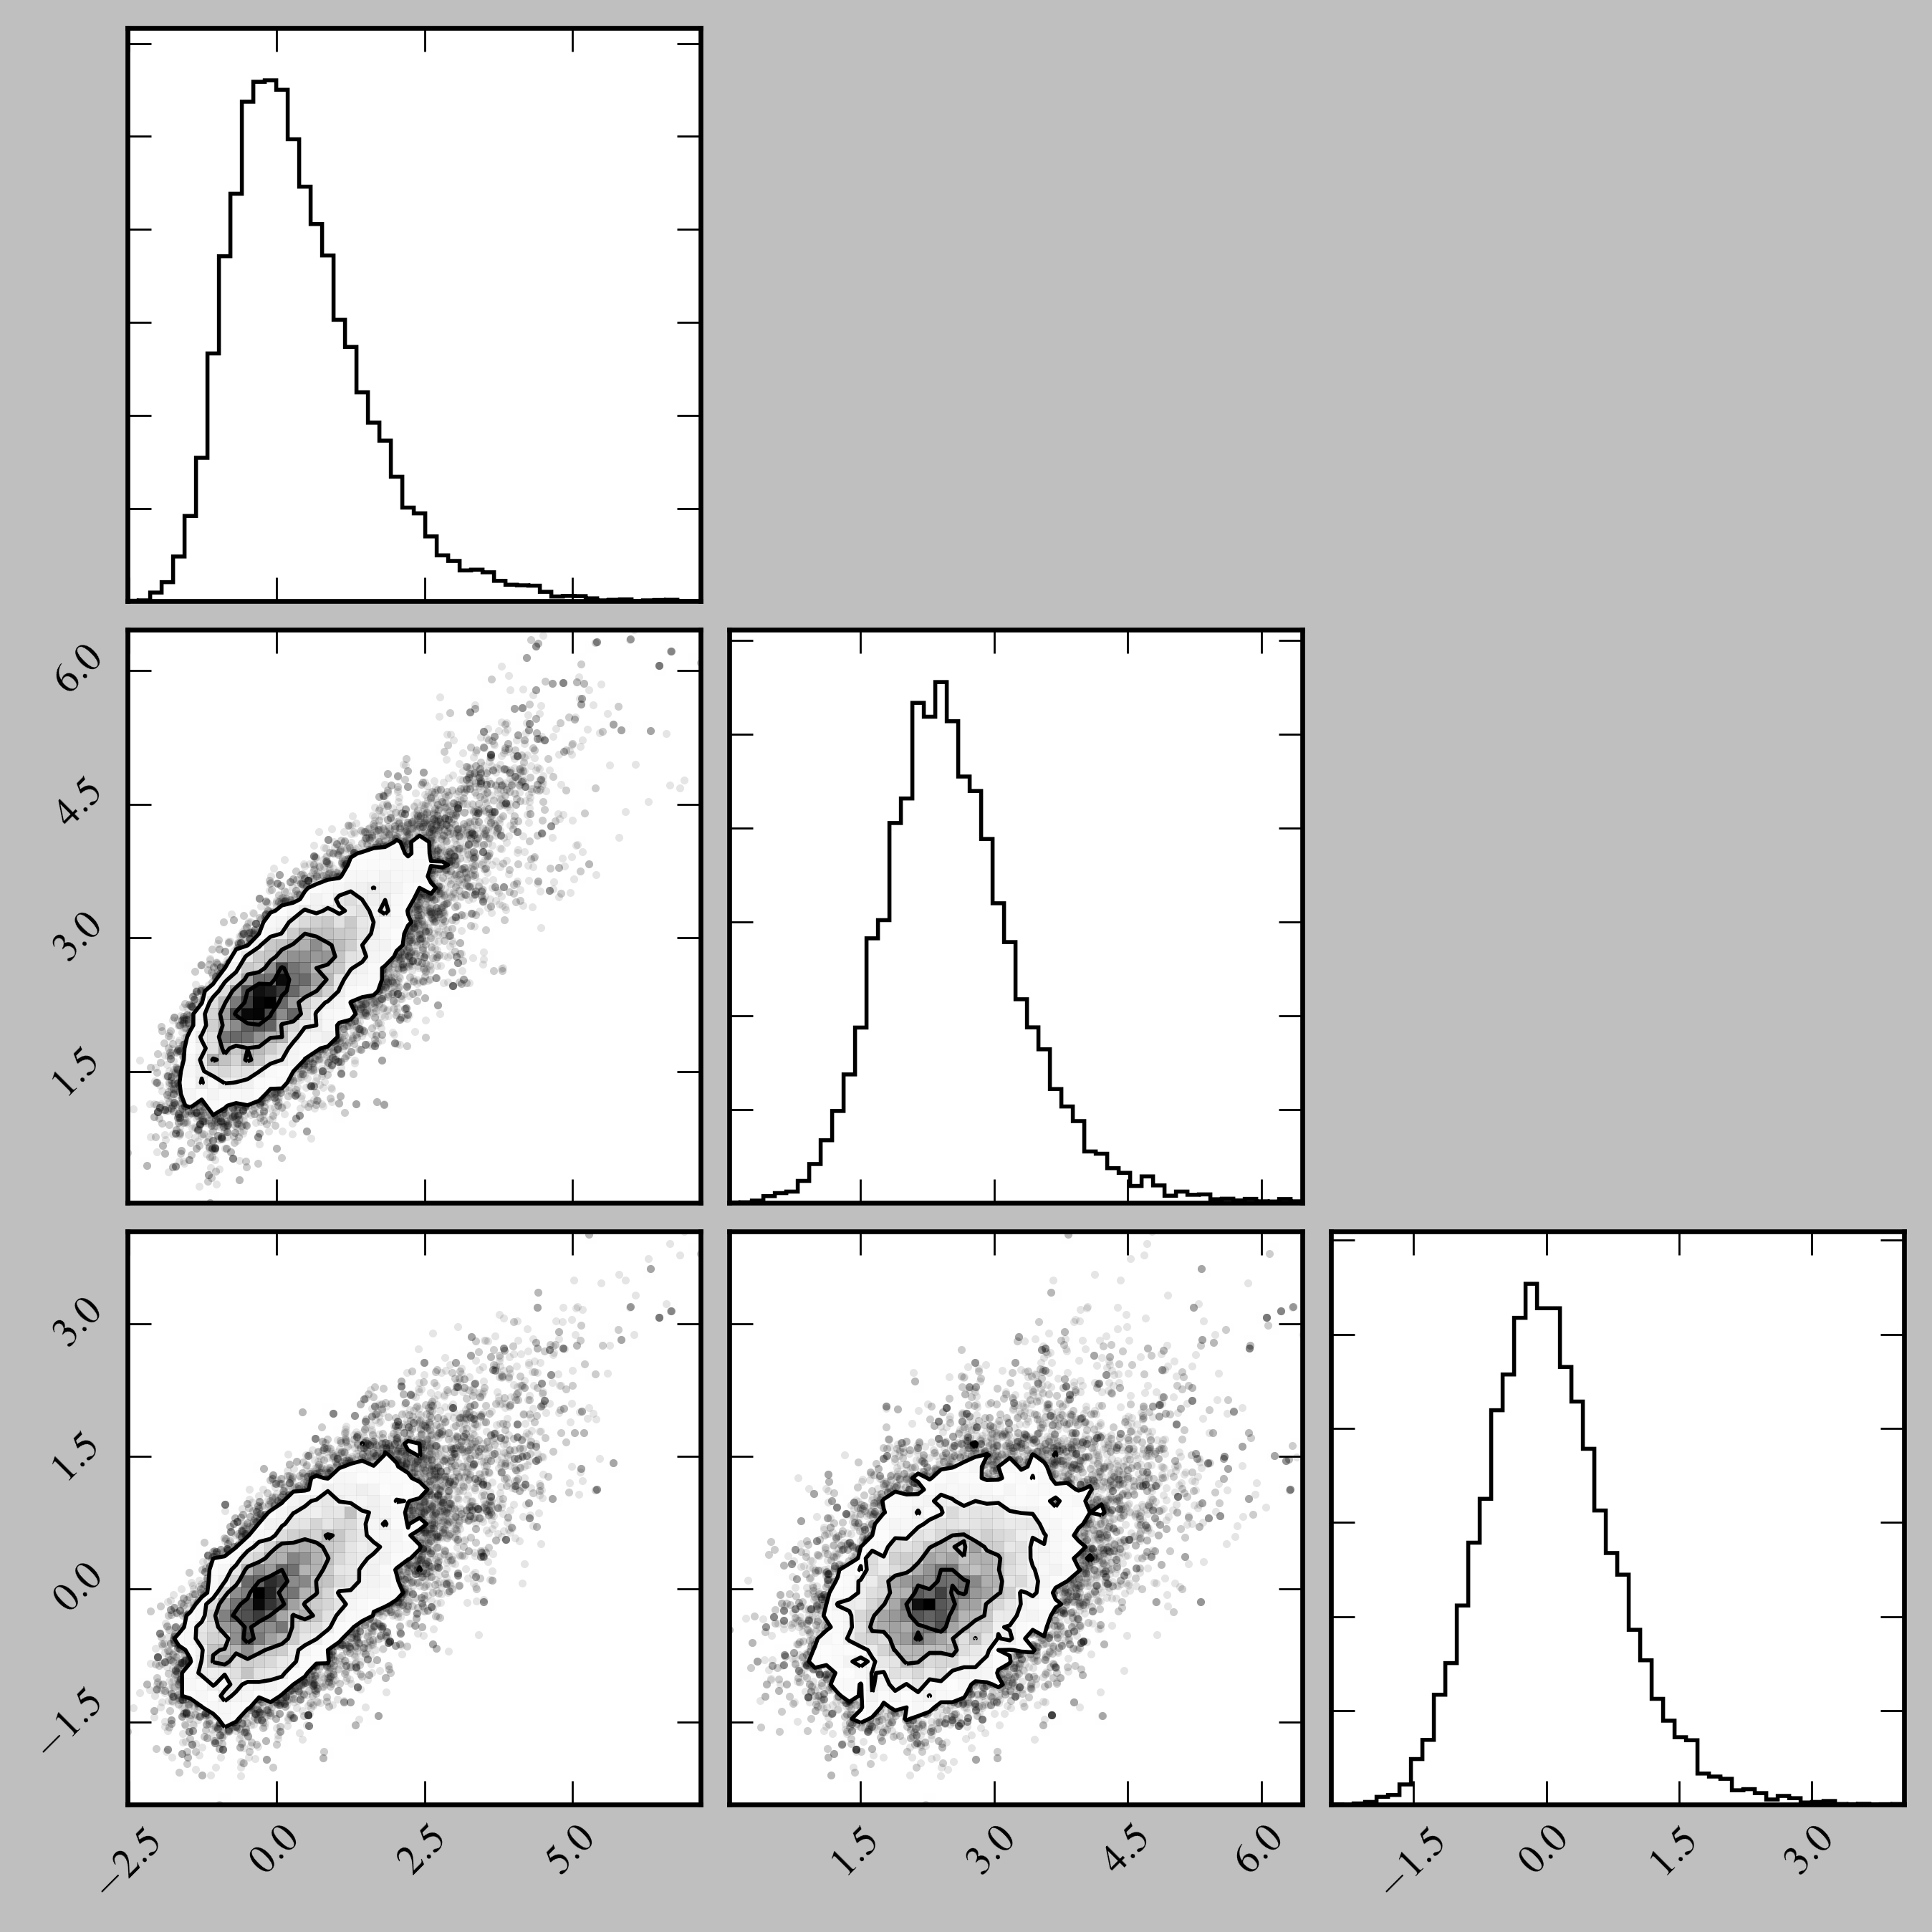

In [33]:
# Let's take a look at the posterior distribution of these kernel parameters.
# The second and third parameters are the natural-log of the kernel length-scales
# in the stellar-density and eccentricity parameters, respectively.

fig = corner.corner(sampler.flatchain,bins=50)
plt.show()

In [34]:
# Let's grab the MAP values

mapparams = np.exp(sampler.flatchain[np.argmax(sampler.flatlnprobability)])

In [35]:
# Set up a GP kernel with the MAP values found from the sampling.

k = mapparams[0] * kernels.ExpSquaredKernel(mapparams[1:],ndim=2)

# Instanciate the GP.
gp = george.GP(k)

# Pre-compute the factorization of the matrix.
gp.compute(xobs, yerr)

# Compute the log likelihood.
print(gp.lnlikelihood(yobs))

131.64970211


In [36]:
# Predict the strain at new astrophysical parameter locations between the training.
# This time though, we use the fully trained GP.

mu, cov = gp.predict(yobs, t)
std = np.sqrt(np.diag(cov))

## Great, so let's now plot the grid of training points, the new predictions across parameter space from the trained GP, and the prediction uncertainties.

## This is Fig. 2 from Taylor, Simon, Sampson (2016). For full details, see the relevant figure caption in the paper.

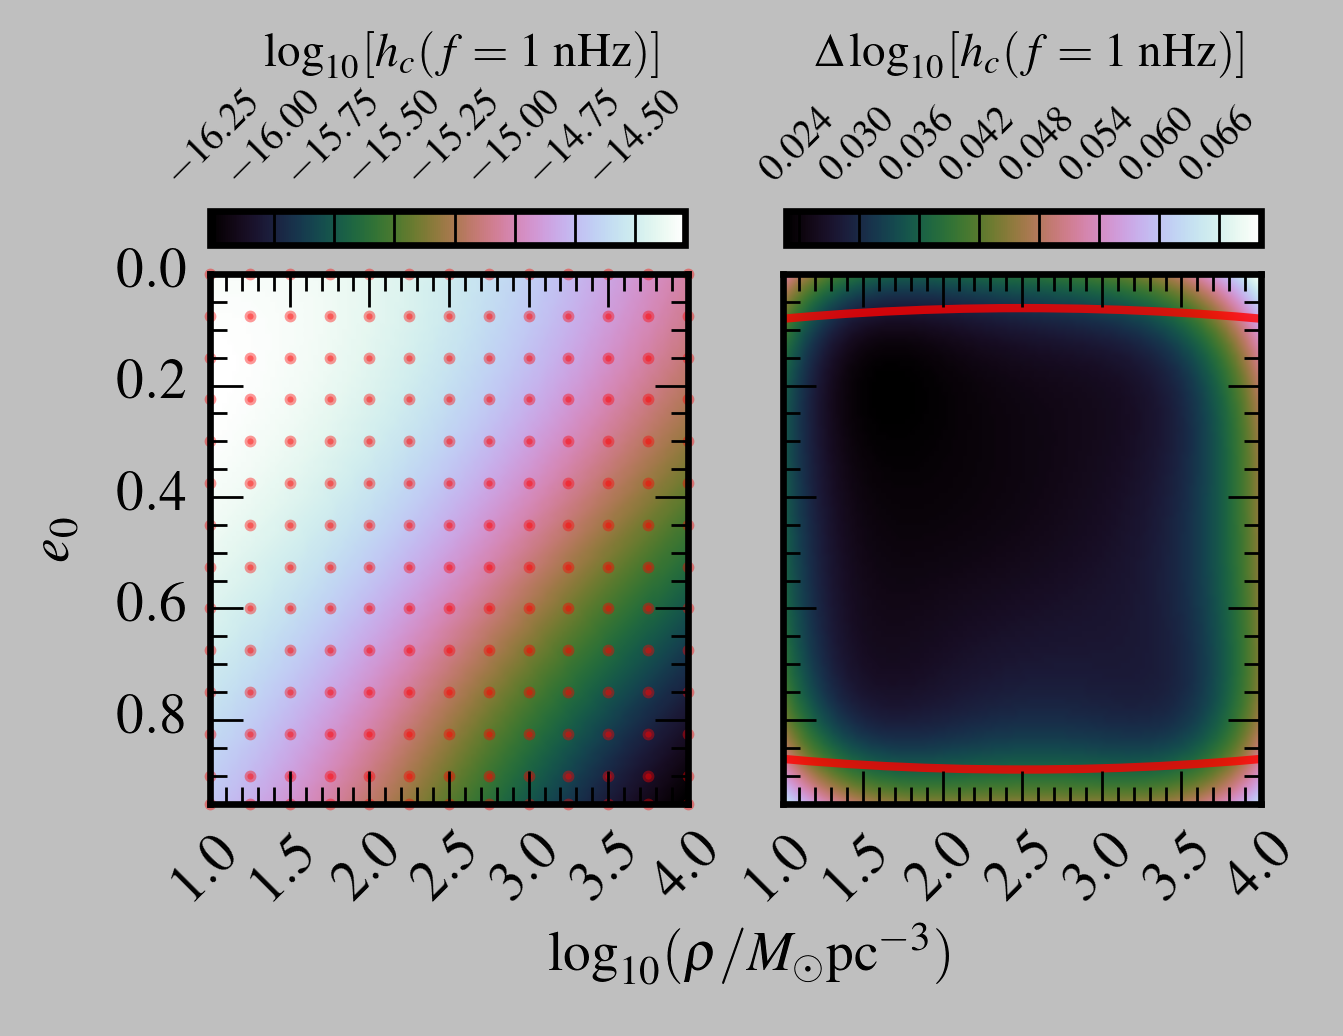

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2) 

im1 = axes[0].imshow(mu.reshape((100,100),order='F')-15.0,extent=(xx.min(),xx.max(),yy.max(),yy.min()),
               cmap=matplotlib.cm.cubehelix, aspect=3.5)#, vmin=0.0579768135068413, vmax=1.0)
im2 = axes[1].imshow(std.reshape((100,100),order='F'),extent=(xx.min(),xx.max(),yy.max(),yy.min()),
               cmap=matplotlib.cm.cubehelix, aspect=3.5)#, vmin=0.0579768135068413, vmax=1.0)

for ii in range(xobs.shape[0]):
    axes[0].scatter(x=xobs[ii,0],y=xobs[ii,1],
                    alpha=0.4,color='r',s=5,marker='.',clip_on=False)

for ax in axes.flat:
    ax.minorticks_on() 
    ax.set_xlim(xx.min(),xx.max())
    ax.set_ylim(yy.max(),yy.min())
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.setp(axes[1].get_yticklabels(), visible=False)

axes[0].set_ylabel(r'$e_0$')

fig.subplots_adjust(wspace=0.2,right=0.9)
cbar_ax = fig.add_axes([0.125, 0.85, 0.35, 0.04])
fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_xticklabels(cbar_ax.get_xticklabels(),rotation=45,size=7)
cbar_ax.xaxis.set_ticks_position('top')

cbar_ax = fig.add_axes([0.55, 0.85, 0.35, 0.04])
fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_xticklabels(cbar_ax.get_xticklabels(),rotation=45,size=7)
cbar_ax.xaxis.set_ticks_position('top')

plt.text(-0.5,-22.0,r'$\log_{10}(\rho / M_\odot\mathrm{pc}^{-3})$')
plt.text(-1.1,5.0,r'$\log_{10}[h_c(f=1\;\mathrm{nHz})]$',fontsize=8.5)
plt.text(0.06,5.0,r'$\Delta \log_{10}[h_c(f=1\;\mathrm{nHz})]$',fontsize=8.5)


from matplotlib.patches import Ellipse   
ellipse = Ellipse(xy=(2.5, 0.475), width=10.02123372/1., height=0.82797949/1., 
                  edgecolor='r', fc='None', lw=1.5, alpha=0.8)
axes[1].add_patch(ellipse)

plt.show()
#fig.savefig('gp4ptas_starsecc_trained.pdf',bbox_inches='tight',dpi=400,rasterized=True)

# We now have the full formalism in place. Let's repreat the above for all frequencies in the GW spectrum, not just the first.

In [39]:
Tobs = 30.0 # years
newfreqs = np.arange(1.0,61.0) / (Tobs*365.25*86400.0)

newwidth = newfreqs[1]-newfreqs[0]
newstrain = np.zeros((data.shape[0],data.shape[1]-1))

finefreqs = data[0,0,:] # same for all parameter inputs
finestrain = data[:,1:,:]
finewidth = finefreqs[1] - finefreqs[0]

In [41]:
# Packs the 2-d data into one long 1-d vector

xobs = np.zeros((len(aa)*len(bb),2))
A, B = np.meshgrid(aa,bb)
xobs[:,0] = A.flatten(order='F') # iterates over all eccentricities then all stellar densities
xobs[:,1] = B.flatten(order='F')

In [42]:
## Re-bin the spectra from a baseline of 100-yrs to 30-yrs.
## This time for all frequencies, 1/(30-yrs) up to 60/(30-yrs).

## Note that we have divided through by 4.5e-31 which is the 
## squared-strain at 1/yr.

yobs = []
yerr = []
for freq_ind in range(len(newfreqs)):
    for ii in range(data.shape[0]):
        for jj in range(data.shape[1]-1):
            mask = np.logical_and(finefreqs >= (newfreqs[freq_ind] - newwidth/2.), 
                                  finefreqs <= (newfreqs[freq_ind] + newwidth/2.))
            newstrain[ii,jj] = np.sum(finestrain[ii,jj,mask]) * finewidth / newwidth 

    # compute mean and std from new binning
    newmean = np.log10(np.mean(newstrain/4.5e-31,axis=1)) 
    
    # cut out bad data, where some population realizations 
    # give zero strain at certain frequencies
    logstrain = np.log10(newstrain/4.5e-31)
    logstrain[logstrain==-np.inf] = 0.0
    
    newerr =  np.std(logstrain,axis=1) 
    
    yobs.append(newmean)
    yerr.append(newerr)

/Users/staylor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


In [20]:
# Instanciate a list of GP kernels and models [one for each frequency]

gp_george = []
k = []

for freq_ind in range(len(newfreqs)):
    
    gp_george.append(gaussproc(xobs,yobs[freq_ind],yerr[freq_ind]))
    k.append( 1.0 * kernels.ExpSquaredKernel([2.0,2.0],ndim=2) )
    num_kpars = len(k[freq_ind])

In [21]:
# Sample the posterior distribution of the kernel parameters 
# to find MAP value for each frequency.

sampler = [0.0]*len(newfreqs)
for freq_ind in range(len(newfreqs)):
    
    # Set up the sampler.
    nwalkers, ndim = 36, num_kpars
    sampler[freq_ind] = emcee.EnsembleSampler(nwalkers, ndim, gp_george[freq_ind].lnprob)

    # Initialize the walkers.
    p0 = [np.log([1.,1.,1.]) + 1e-4 * np.random.randn(ndim)
          for i in range(nwalkers)]

    print freq_ind, "Running burn-in"
    p0, lnp, _ = sampler[freq_ind].run_mcmc(p0, 500)
    sampler[freq_ind].reset()

    print freq_ind, "Running second burn-in"
    p = p0[np.argmax(lnp)]
    p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler[freq_ind].run_mcmc(p0, 500)
    sampler[freq_ind].reset()

    print freq_ind, "Running production", '\n'
    p0, _, _ = sampler[freq_ind].run_mcmc(p0, 1000)

Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-in
Running second burn-in
Running production
Running burn-i

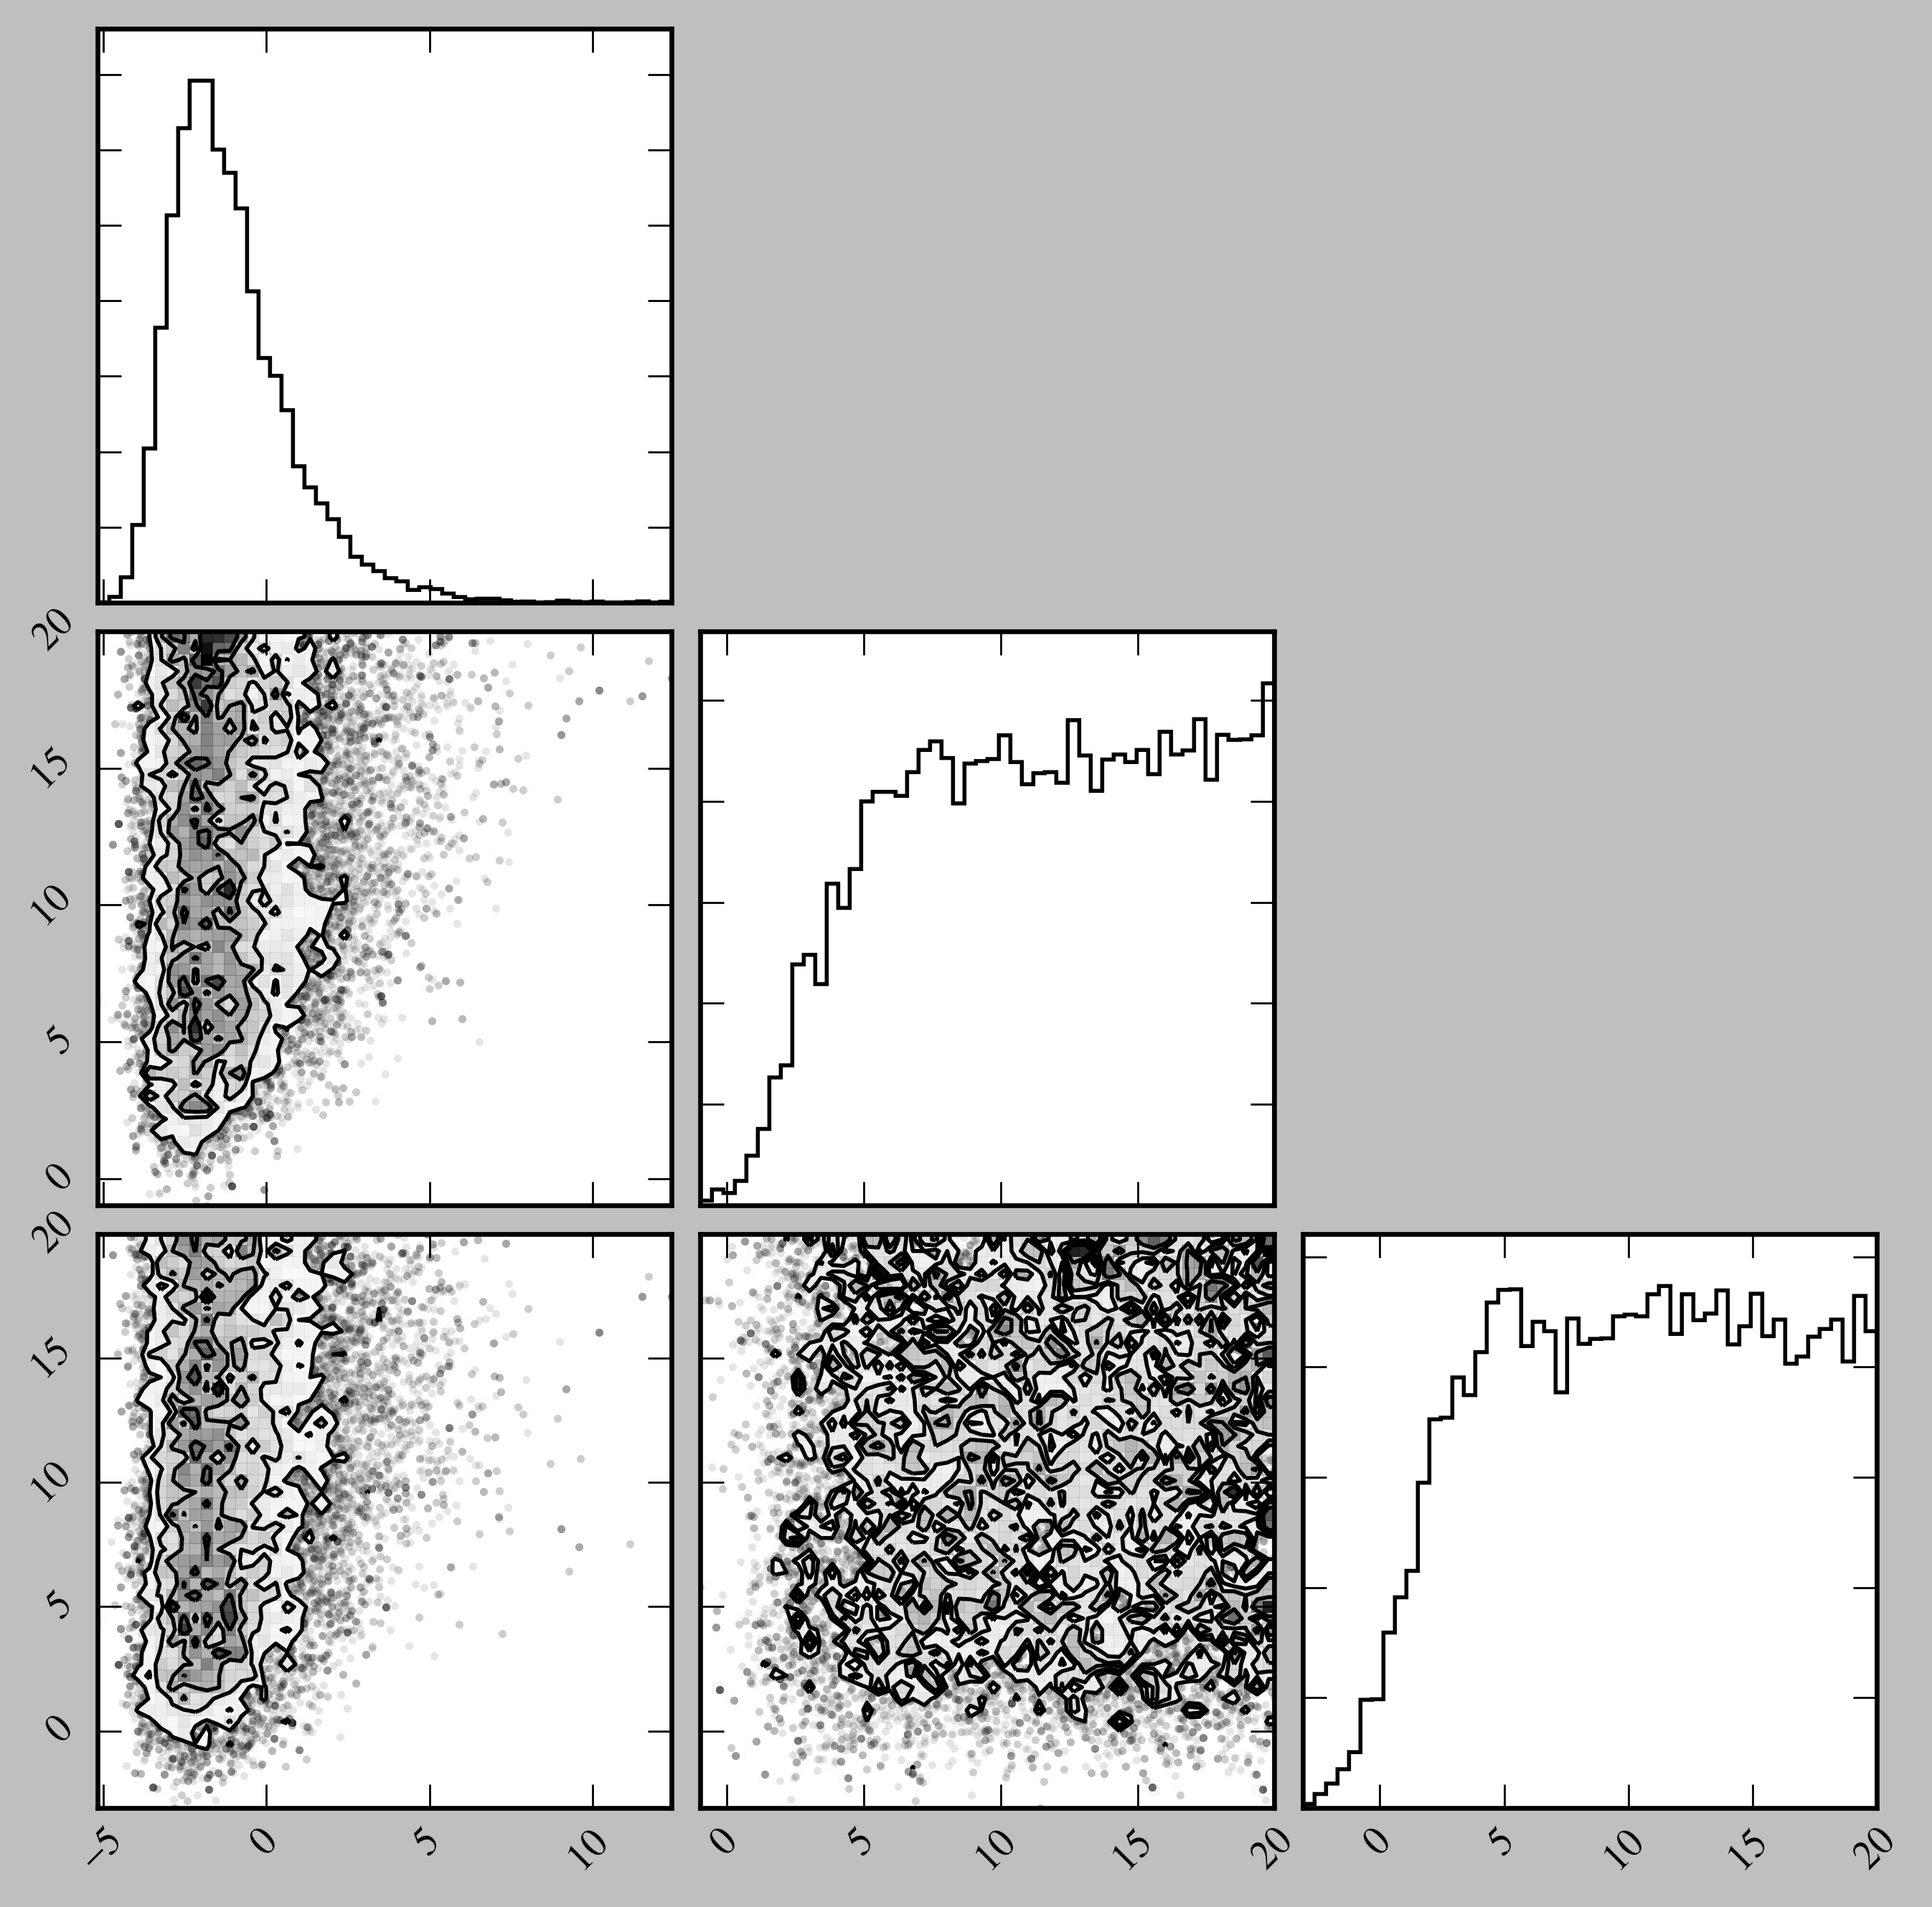

In [24]:
## Let's take a look at the posterior distribution of the 
# kernel parameters at a frequency [ind] of our choice.

ind = 59

fig = corner.corner(sampler[ind].flatchain,bins=50)
plt.show()

In [25]:
## Populate the GP class with the details of the kernel 
## MAP values for each frequency.

for ii in range(len(newfreqs)):
    
    gp_george[ii].chain = None 
    gp_george[ii].lnprob = None 
    
    gp_george[ii].kernel_map = sampler[ii].flatchain[np.argmax(sampler[ii].flatlnprobability)] 
    print ii, gp_george[ii].kernel_map

0 [ 1.14990985  2.34923935 -0.11589336]
1 [ 1.0372761   2.22583921  0.01661058]
2 [ 0.29330017  1.88892611 -0.28082725]
3 [ 0.15186919  1.78775733 -0.19058457]
4 [-0.28251632  1.60326149 -0.29196531]
5 [-0.33816674  1.68552604 -0.25253041]
6 [-0.78645256  1.40226458 -0.36320196]
7 [-0.77461997  1.64439646 -0.1234711 ]
8 [-1.16556389  1.5089904  -0.08139505]
9 [-1.24376098  1.72997902  0.19340532]
10 [-1.65583447  1.50049794 -0.11629366]
11 [-1.58999546  1.83022237  0.24203229]
12 [-1.56615746  1.8231646   0.33420006]
13 [ -2.2208634    2.14918231  10.34452365]
14 [ -1.27003498   7.43881673  14.36296727]
15 [ -2.54643144   2.10047285  14.92289728]
16 [ -1.60903495  18.18504579  17.2975834 ]
17 [ -2.43715856  18.71326525  17.69953603]
18 [ -1.89893537  15.55736145   5.62274382]
19 [ -2.95646749  19.73813399  16.26638941]
20 [ -2.17813196  17.92037972  17.88126181]
21 [ -3.50244168  13.34461058   1.04907005]
22 [ -2.63167949  19.41484444   2.74918494]
23 [ -4.48275477  13.61924461   0.155

# Store GP object for each frequency as a pickle. 

# This pickle object is now ready to be used in NX01 to constrain astrophysical parameters using real PTA data.

In [26]:
pickle.dump(gp_george, open( "starsecc_gp_13x14nodes_30yr.pkl", "wb" ))